# Exercise 9: Multivariate Classification

This exercise is dedicated to studies of a multivariate data-set, the famous 'Iris flower data-set' used in the year 1936 by 
Sir Ronald Fisher as an example of discriminant analysis. The data-set describes the morphological variation of Iris flowers and contains 50 samples from each of the three species Iris-setosa, Iris-virginica and Iris-versicolor.

The file `iris.data` (available in the exercise repository and cloned into this directory) contains the data. The columns contain four morphological features of the three species: the sepal length and width and the petal length and width (all in $\mathrm{cm}$), and the species as classified by a botanist (Iris-setosa = 0, Iris-versicolor= 1, Iris-virginica = 2). Fortunately, the biological details are not of too much importance for the studies proposed here, and you may safely name the variables $v_1, \ldots, v_4$ and call the classes '1', '2' and '3'.
In this exercise you will develop classifiers based on this data-set as a training sample to identify different iris species, for people who are not particularly gifted botanists.

To guide your own implementation of studies of the data-set, a code basis is provided in this jupyter notebook. Inspect it and use it as a starting point for your own work. 

In [1]:
"""
.. module:: ex9_template
    :synopsis example for discriminant analysis

.. moduleauthor Thomas Keck
"""
# ------------------------------------------------------------------------
# useful imports

import bisect
import numpy as np

import matplotlib
# matplotlib.rcParams['backend'] = 'TkAgg'

from matplotlib import pyplot as plt

# ------- load the Data set --------------------------------------------
# Load iris data
data = np.loadtxt('iris.data')

# Define dictionary with columns names: s=sepal, p=petal, l=lenght, w=width,
columns = {0: 'L(Kelch)', 1: 'W(Kelch)',
           2: 'L(Blatt)', 3: 'W(Blatt)', 4: 'class'}

# Define boolean arrays corresponding to the three
#      classes setosa, versicolor and virginica
setosa = data[:, 4] == 0
versicolor = data[:, 4] == 1
virginica = data[:, 4] == 2

# Signal is versicolor (can be changed to setosa or virginica)
signal = versicolor
bckgrd = ~signal
# !! note: see indexing of arrays with boolean array in python documentation
#
# exmaples how to access the data:
#    data[signal]     # All events classified as signal
#    data[background] # All events classified as background
#    data[setosa]     # All events classified as setosa
#    data[versicolor | virginica] # All events classified as versicolor or virginica
#    data[:, :2]      # The first two columns (sepal length and sepal width) of all events
#    data[signal, :2] # The first two columns of the signal events
#    data[background, 2:4] # The 3. and 4. column (petal length and petal width) of the background events
#    data[:, 4]       # The label column of all events
#             (see the numpy documentation for further examples)

### Exercise 9.1: (voluntary)

In multivariate analyses, it is most important to gain an overview and some initial level of understanding before deciding
on strategies for optimal classification. One-dimensional distributions (=histograms) and pair-wise scatter plots of the 
available features (=variables) are the best way to visualise the available raw information. Plot the distributions for all features, ideally arranged as two-dimensional array of histograms (on the diagonal) and scatter plots (off-diagonal). You can use the examples in the template class `Plotter` defined in [Exercise 9.2](#exercise92) to make these plots. With appropriate colour coding, all three classes of the data-set can be shown in the same set of histograms. 
     
Which variables provide the best separation of Iris-setosa from the other two species? How can Iris-versicolor or Iris-virginica be separated from the others?

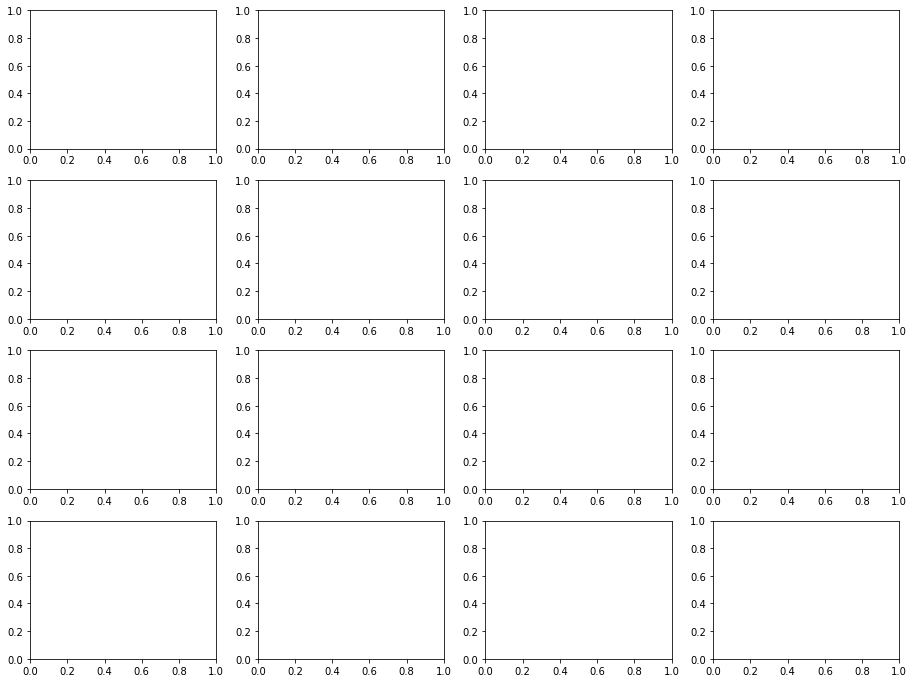

In [2]:
# ------------------------------------------------------------------
# Exercise 1
nvar = 4
f, axarr = plt.subplots(nvar, nvar, figsize=[12.8, 9.6])
plt.tight_layout()
nbins = 20
# add your code here ...

plt.show()

### Exercise 9.2: Naive Likelihood-Ratio (obligatory)
In the obligatory parts of this exercise, we only use the first two variables in each line of the data-set, the sepal length and width, to separate one of the species, the 'signal', from the other two, the 'background' in order to simplify the visualization of the results.

Study the example code, which contains a general python class `Plotter`, which provides methods to display several aspects for the evaluation of the performance of a classifier. The classifier itself is to be implemented as another class containing a method `evaluate()` (an example classifier class is given [below](#cutclass)), which returns the value of the test-statistic under study and is used by the class `Plotter`. The method `plot_contour()` implemented in this class draws scatter plots of the data superimposed with contours representing the result of evaluation of the test-statistic. Also included is a method `plot_test_statistic()` to display the distributions of the test-statistic on background and signal samples, and a method `plot_roc()` to visualise the performance, the so-called 'ROC' curve.
<a name=exercise92></a>

In [3]:
# ------- helper functions ----------------------------------


class Plotter(object):
    """
        class to display and evaluate the performance of a test-statistic
    """

    def __init__(self, signal_data, bckgrd_data):
        self.signal_data = signal_data
        self.bckgrd_data = bckgrd_data
        self.data = np.vstack([signal_data, bckgrd_data])

    def plot_contour(self, classifier):
        # 1st variable as x-dimension in the plots
        xdim = 0
        # and 2nd variable as y-dimension
        ydim = 1
        # Draw the scatter-plots of signal and background
        ax = plt.subplot()
        ax.scatter(self.signal_data[:, xdim], self.signal_data[:, ydim],
                    c='r', label='Signal')
        ax.scatter(self.bckgrd_data[:, xdim], self.bckgrd_data[:, ydim],
                    c='b', label='Background')

        # Evaluate the response function on a two-dimensional grid ...
        #   ... using the mean-values of the data for the remaining dimensions.
        xs = np.arange(min(self.data[:, xdim]) - 1, max(self.data[:, xdim]) + 1, 0.1)
        ys = np.arange(min(self.data[:, ydim]) - 1, max(self.data[:, ydim]) + 1, 0.1)

        means = np.mean(self.data, axis=0)  # calculate mean of each column
        responses = np.zeros((len(ys), len(xs)))
        for i, x in enumerate(xs):
            for j, y in enumerate(ys):
                values = np.copy(means)
                values[xdim] = x
                values[ydim] = y
                responses[j, i] = float(classifier.evaluate(values))

        # Draw a contour plot
        X, Y = np.meshgrid(xs, ys)
        c = ax.contourf(X, Y, responses, alpha=0.5, cmap=plt.cm.coolwarm)
        cbar = plt.colorbar(c, orientation='vertical', ax=ax)
        # add the direction of the fisher vector (if specified)
        if hasattr(classifier, 'fisher_vector'):
            vector = classifier.fisher_vector / np.linalg.norm(classifier.fisher_vector)
            ax.set_aspect('equal', 'datalim')
            ax.plot([-vector[xdim] + means[xdim], vector[xdim] + means[xdim]],
                     [-vector[ydim] + means[ydim], vector[ydim] + means[ydim]],
                     'k-', lw=4, label="Fisher Projection")
        plt.title(
            "scatter plot {} vs {} and classifier contour".format(
                columns[xdim], columns[ydim]))
        # cbar.draw_all()
        plt.show()

    def plot_test_statistic(self, classifier):
        # Draw Distribution of the test-statistic
        ns, binss, _ = plt.hist(list(map(classifier.evaluate, self.signal_data)),
                                color='r', alpha=0.5, label='Signal')
        nb, binsb, _ = plt.hist(list(map(classifier.evaluate, self.bckgrd_data)),
                                color='b', alpha=0.5, label='Background')
        plt.title("test statistic")
        plt.show()

    # calculate efficiencies and plot ROC-curves
    def plot_roc(self, classifier):
        ns, binss = np.histogram(list(map(classifier.evaluate, self.signal_data)))
        nb, binsb = np.histogram(list(map(classifier.evaluate, self.bckgrd_data)))
        # enforce common binning for response on bkg and sig
        minresp = min([binss[0], binsb[0]])
        maxresp = max([binss[len(binss) - 1], binsb[len(binsb) - 1]])
        nbins = 100
        bins = np.linspace(minresp, maxresp, nbins)
        bwid = (maxresp - minresp) / nbins
        # calculate cumulative distributions (i.e. bkg and sig efficiencies)
        h, b = np.histogram(list(map(classifier.evaluate, self.signal_data)), bins, density=True)
        ns = np.cumsum(h) * bwid
        h, b = np.histogram(list(map(classifier.evaluate, self.bckgrd_data)), bins, density=True)
        nb = np.cumsum(h) * bwid
        # finally, draw bkg-eff vs. sig-eff
        f2, ax = plt.subplots(1, 1)
        ax.plot(1. - ns, nb, 'r-', 1. - ns, nb, 'bo', linewidth=2.0)
        ax.set_xlabel("signal efficiency")
        ax.set_ylabel("background rejection")
        ax.set_title("ROC curve")
        plt.show()


def find_bin(x, edges):
    """
        returns the bin number (in array of bin edges) corresponding to x
        @param x: value for which to find correspoding bin number
        @param edges: array of bin edges
    """
    return max(min(bisect.bisect(edges, x) - 1, len(edges) - 2), 0)

To guide your implementation of the naive likelihood-ratio classifier an implementation example of a classifier class is given below. The class `CutClassifier` implements a simple, cut-based analysis, where the method `evaluate(x)` simply returns the number of cuts satisfied by the point in variable space given in the array $x$.
<a name=cutclass></a>

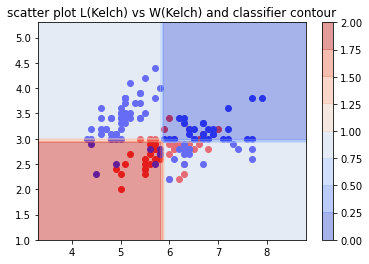

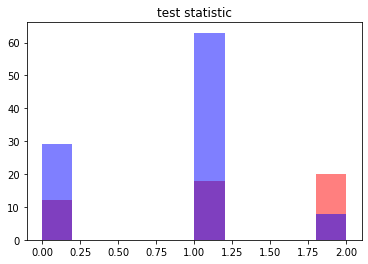

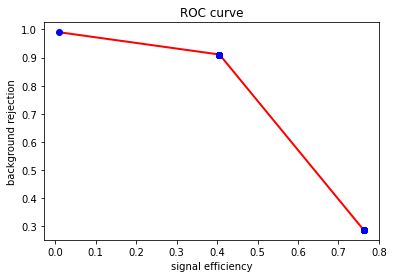

In [4]:
# ------- simple example: Classifier and usage with Plotter class ---------

# template of Classifier Class
class CutClassifier(object):
    """
        template implementation of a Classifier Class
    """

    def fit(self, signal_data, bckgrd_data):
        """
            set up classifier ("training")
        """
    # some examples of what might be useful:
        # 1. signal and background histograms with same binning
        _, self.edges = np.histogramdd(np.vstack([signal_data, bckgrd_data]), bins=10)
        self.signal_hist, _ = np.histogramdd(signal_data, bins=self.edges)
        self.bckgrd_hist, _ = np.histogramdd(bckgrd_data, bins=self.edges)

        # 2. mean and covariance matrix
        self.signal_mean = np.mean(signal_data, axis=0)
        self.signal_cov = np.cov(signal_data.T)
        self.bckgrd_mean = np.mean(bckgrd_data, axis=0)
        self.bckgrd_cov = np.cov(bckgrd_data.T)

    def evaluate(self, x):
        # simple example of a cut-based classifier
        c = 0
        for i in range(len(x)):
            c += (x[i] < (self.signal_mean[i] + self.bckgrd_mean[i]) / 2.)
        return c

# example how to use a Classifier Class with the Plotter Class
ndim = 2

# initialise Classifier with training data
cut = CutClassifier()
cut.fit(data[signal, :ndim], data[bckgrd, :ndim])

# initialize Plotter Class
plotter = Plotter(data[signal, :ndim], data[bckgrd, :ndim])
# and make plots
plotter.plot_contour(cut)
plotter.plot_test_statistic(cut)
plotter.plot_roc(cut)

As a very simple approach, we start by building a two-dimensional histogram of the likelihood ratio of the signal and background distributions. First, choose a 'suitable' binning, and then, in each bin, determine the signal-to-background ratio, which already is the desired likelihood ratio in the bin. 

Implement a class in analogy to the example provided in `CutClassifier`. In particular, implement the method `evaluate(x)` for your new class that returns the likelihood-ratio for each bin corresponding to the test point $x$.

Use Iris-versicolor as the signal, the other species as background. Visualise the results in the two-dimensional parameter space using the methods of the provided class `Plotter`.

What are the problems of this simple approach?
What happens if you use Iris-setosa as the signal?

**Hint**: Use the `numpy` function `histogram2d` (or `histogramdd`) to create a two-dimensional histogram. You may profit from the function `find_bin` defined in the provided code basis to find the bin which corresponds to a given point in variable space. 

In [5]:
# -----------------------------------------------------------------
# Exercise 2

### Exercise 9.3: Logarithm of Likelihood-Ratio (obligatory)
  
Next, we use parametrised distributions, assuming that the signal and background distributions can be reasonably described by two-dimensional Gaussian distributions, defined by the mean values and covariance matrices of the signal and background data-sets.

Implement a class with a method `evaluate` returning the logarithm of the likelihood-ratio for each point in the sample.

Visualise your results, as in the previous exercise, with Iris-versicolor as the signal. 

What is the advantage of this approach compared to the previous case? 
What happens if you use Iris-setosa as signal?

**Hint**: The `numpy` functions `mean`, `cov`, `.dot` and `linalg.inv` are very helpful for this problem. 

In [6]:
# ------------------------------------------------------------------
# Exercise 3

  
### Exercise 9.4: Fisher's discriminant (obligatory)

In order to study a truly one-dimensional classifier, implement Fisher's discriminant. Write an appropriate class which calculates the Fisher vector in the `fit()` method, and write a method `evaluate(x)` returning the projection of the feature vector $x$ onto the fisher vector, and study the resulting plots. Use again Iris-versicolor as the signal.
  
What is better in this approach, and where are possible limitations? What happens if you use Iris-setosa as signal?

In [7]:
# ------------------------------------------------------------------
# Exercise 4

### Exercise 9.5:  (voluntary)

With the code implemented so far, you are ready now to use the full four-dimensional data, _i.e._ to employ all four features (sepal length, sepal width, petal length, petal width), hopefully with only minor modifications or additions to your code. 

Is it useful to consider the approaches of exercises 9.2 and 9.3 (naive likelihood-ratio in histogram bins, or the parametrisations
of signal an background by four-dimensional Gaussian distributions) in the four-dimensional feature space?

With your implementation of Fisher's Method you are ready to separate better even Iris-virginica and Iris-versicolor. 
Give it a try!

**Remark**: The basic code skeleton you have developed in this exercise can easily be used for other data-sets, and an extension by other methods, _e.g._ those mentioned in the lecture, is also thinkable.

In [8]:
# ------------------------------------------------------------------
# Exercise 5
#   -> Set ndim to 4